## GRUs for Twitter Sentiment Analysis

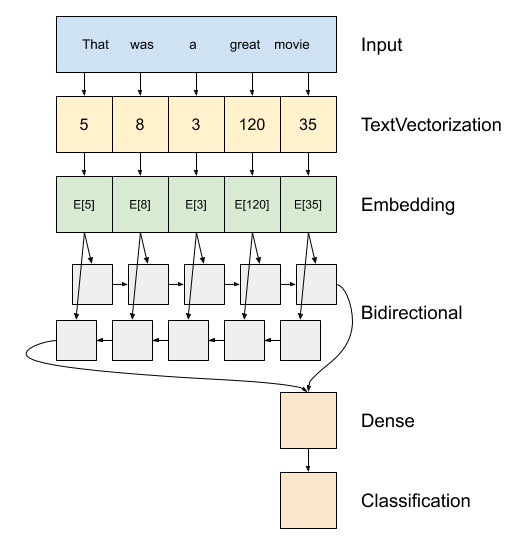

Image link: https://www.tensorflow.org/text/tutorials/text_classification_rnn

The text classifier built in the tutorial from the link above was built for movie reviews. Movie reviews are always formally written and there are rarely any slangs or emojis to convey one's beliefs(or emotions). Twitter texts are full of words that may be meaningless unless any context is present; this is why the following RNN is buing built using GRU as our architecture because:

- Contextual information is preserved
- It has less number of gates as compared to LSTMs and we want to be able to train this model on CPUs.

For the results of a simple model which only makes use of an embedding vector, there is another notebook in this repo which does that. Let's build the two models and compare our results.

## Creating Class

In [1]:
class Tweet():
    def __init__(self, text, label):
        self.text = text
        self.label = label

class Utils():
    def __init__(self, tweets):
        self.tweets = tweets
        
    def get_text(self):
        return [x.text for x in self.tweets]
    
    def get_label(self):
        return [x.label for x in self.tweets]

## Imports

In [10]:
import tensorflow as tf
import json

from tensorflow.keras import Sequential

from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import Dense, Embedding, Bidirectional, GRU, Dropout

## Process Data

### Read data from json file


In [4]:
file_name = '../data/Data_processed.json'

tweets = []
with open(file_name) as f:
    for line in f:
        tweet = json.loads(line)
        tweets.append(Tweet(tweet['Text'], tweet['Target']))
    
# Taking a look at an example of our data
print(tweets[0].text)
print(tweets[0].label)

   awww thats a bummer  you shoulda got david carr of third day to do it d
0


## Creating our tensorflow model

### Setting hyper-parameters

In [12]:
BATCH_SIZE = 1024
SEED = 123
DENSE_NODES = 16
OPTIMIZER = tf.keras.optimizers.Adam(1e-4)
METRICS = ['accuracy']
EPOCHS = 5
VOCAB_SIZE = 10000
SEQUENCE_LEN = 50
EMBEDDING_DIM = 16

### Creating text/label datasets

In [6]:
dataset_text = Utils(tweets).get_text()
dataset_labels = Utils(tweets).get_label()

ds_labels = tf.convert_to_tensor(dataset_labels)
ds_text = tf.convert_to_tensor(dataset_text)

2022-02-17 19:42:14.328467: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-02-17 19:42:14.328514: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-17 19:42:14.328535: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (mik-HP-EliteBook-840-G2): /proc/driver/nvidia/version does not exist
2022-02-17 19:42:14.328793: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### For creating our TextVectorizer Vocab(Encoder)

In [7]:
p_text = tf.data.Dataset.from_tensors(ds_text)

## Text Vectorization

Use the text vectorization layer to normalize, split, and map strings to integers. Note that the layer uses the custom standardization defined above.Set maximum_sequence length as all samples are not of the same length.

Calling adapt mathod to build vocabulary from training dataset while also transforming our test dataset for future.

In [9]:
encoder = TextVectorization(standardize='lower_and_strip_punctuation',
                                   max_tokens=VOCAB_SIZE,
                                   split='whitespace',
                                   output_mode='int',
                                   output_sequence_length=SEQUENCE_LEN)

encoder.adapt(p_text)

2022-02-17 19:48:18.421156: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 316989920 exceeds 10% of free system memory.
2022-02-17 19:48:18.421228: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 475484880 exceeds 10% of free system memory.


## Model

### Create Model

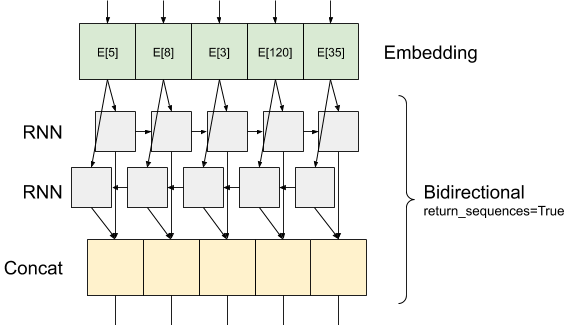

We stack two or more GRUs for better performance, read docx for more details

Image link: https://www.tensorflow.org/text/tutorials/text_classification_rnn

In [11]:
model = Sequential([
    encoder,
    Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    Bidirectional(GRU(units=64,  return_sequences=True)),
    Bidirectional(GRU(units=32, return_sequences=False)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

### Compile and train model

In [14]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer=OPTIMIZER,
              metrics=METRICS)

model.fit(x=ds_text,
          y=ds_labels,
          epochs=EPOCHS,
          validation_split=0.1,
          validation_steps=30)


Epoch 1/5
  265/45000 [..............................] - ETA: 1:03:54 - loss: 0.6854 - accuracy: 0.5519

KeyboardInterrupt: 